In [2]:
from datetime import datetime
import gpt_2_simple as gpt2
import pandas as pd
from transformers import GPT2Tokenizer

/home/navidha/miniconda3/envs/tf_env/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(
2023-04-23 19:43:20.989570: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-23 19:43:21.044240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 19:43:22.109772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/navidha/min

**Downloading GPT2 124M model**

In [10]:
gpt2.download_gpt2(model_name="124M")

Fetching checkpoint: 1.05Mit [00:00, 321Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:01, 574kit/s]                                                    
Fetching hparams.json: 1.05Mit [00:00, 506Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [17:50, 465kit/s]                                   
Fetching model.ckpt.index: 1.05Mit [00:00, 652Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:01, 814kit/s]                                                 
Fetching vocab.bpe: 1.05Mit [00:01, 824kit/s]                                                       


**Mounting google drive and copying the training file**

In [12]:
file_name = "train.txt"

**Finetuning GPT2 model for our Trainset**

In [ ]:
sess = gpt2.start_tf_sess()
gpt2.finetune(sess,
              dataset=file_name,
              model_name='124M',
              steps=5000,
              restore_from='Fresh',
              run_name='run1',
              print_every=10,
              sample_every=200,
              save_every=500
              )

**Load the model**

In [3]:
sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, run_name='runf')

2023-04-23 19:43:31.491723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7484 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-04-23 19:43:31.492527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6898 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2023-04-23 19:43:31.493245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 6898 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2023-04-23 19:43:33.419662: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Loading checkpoint checkpoint/runf/model-5000
INFO:tensorflow:Restoring parameters from checkpoint/runf/model-5000


**TESTING**

In [3]:
test_data = pd.read_csv("test.csv")
queries = list(test_data["input_text"])
responses = list(test_data["target_text"])


In [5]:
generated_responses=[]
for i in queries:
  pref = "question: "+i+" context:"
  gpt2.generate_to_file(sess,
                destination_path="out.txt",
                prefix= pref,
                top_k=10, 
                top_p=0.7,
                temperature = 0.8,
                nsamples=1,
                batch_size=1,
                run_name='run1',
                truncate=' <|endoftext|>',
                include_prefix=False,
                )
  out_file = open("out.txt","r+")
  generated_responses.append(out_file.read()[:-2])
  print(len(generated_responses))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


In [7]:
pred = pd.DataFrame(columns=["Query","Response","Generated Response"])
pred["Query"]=queries
pred["Response"]= responses
pred["Generated Response"] = generated_responses
pred.to_csv("Results.csv")

**Metrics**

In [8]:
!pip install "nltk==3.4.5"

  Using cached nltk-3.4.5-py3-none-any.whl


In [9]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.nist_score import sentence_nist


In [10]:
def get_metrics(pred, target):
    turns = len(target)
    bleu_2 = 0
    bleu_4 = 0
    meteor = 0
    nist_2 = 0
    nist_4 = 0
    for index in range(turns):
        pred_utt = pred[index]
        target_utt = target[index]
        min_len = min(len(pred_utt), len(target_utt))
        lens = min(min_len, 4)
        if lens == 0:
            continue
        if lens >= 4:
            bleu_4_utt = sentence_bleu([target_utt], pred_utt, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = SmoothingFunction().method1)
            nist_4_utt = sentence_nist([target_utt], pred_utt, 4)
        else:
            bleu_4_utt = 0
            nist_4_utt = 0
        if lens >= 2:
            bleu_2_utt = sentence_bleu([target_utt], pred_utt, weights = (0.5, 0.5), smoothing_function = SmoothingFunction().method1)
            nist_2_utt = sentence_nist([target_utt], pred_utt, 2)
        else:
            bleu_2_utt = 0
            nist_2_utt = 0
            
        bleu_2 += bleu_2_utt
        bleu_4 += bleu_4_utt
        meteor += meteor_score([" ".join(target_utt)], " ".join(pred_utt))
        nist_2 += nist_2_utt
        nist_4 += nist_4_utt
        
    bleu_2 /= turns
    bleu_4 /= turns
    meteor /= turns
    nist_2 /= turns
    nist_4 /= turns
    return bleu_2, bleu_4, meteor, nist_2, nist_4


In [11]:
nltk.download('wordnet')
bleu_2, bleu_4, meteor, nist_2, nist_4 = get_metrics(generated_responses, responses)

[nltk_data] Downloading package wordnet to /home/navidha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
print("bleu_2",bleu_2)
print("bleu_4",bleu_4)
print("meteor",meteor)
print("nist_2",nist_2)
print("nist_4",nist_4)

bleu_2 0.3681392715705741
bleu_4 0.2504935456423313
meteor 0.35994374360752923
nist_2 2.399633818486239
nist_4 2.7366025490061476


Predicted Response Anlaysis

In [18]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 973.0 kB/s eta 0:00:00a 0:00:01


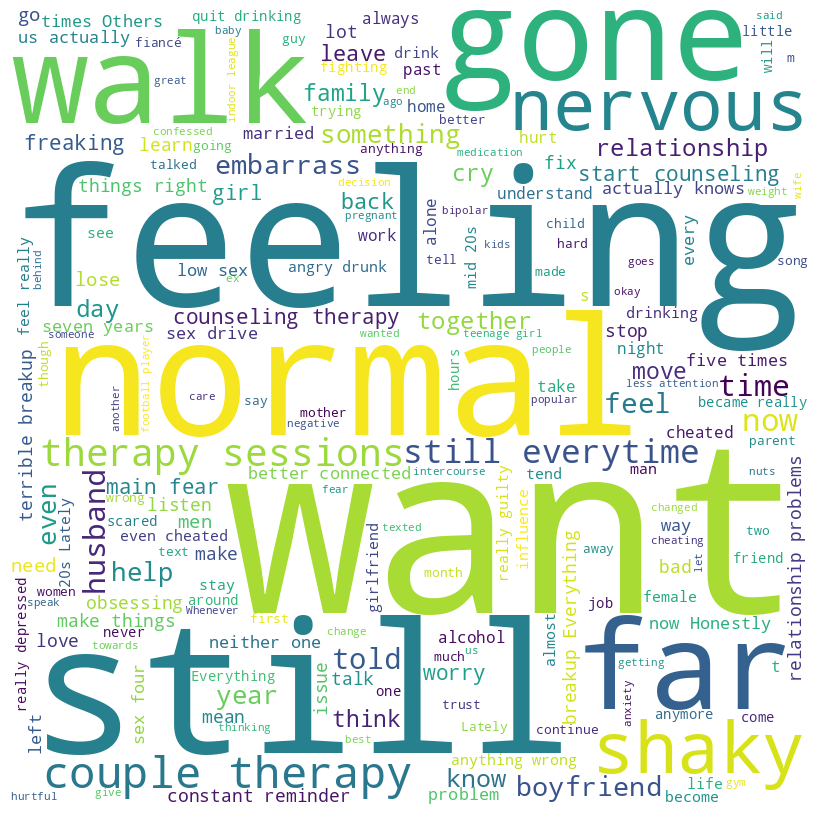

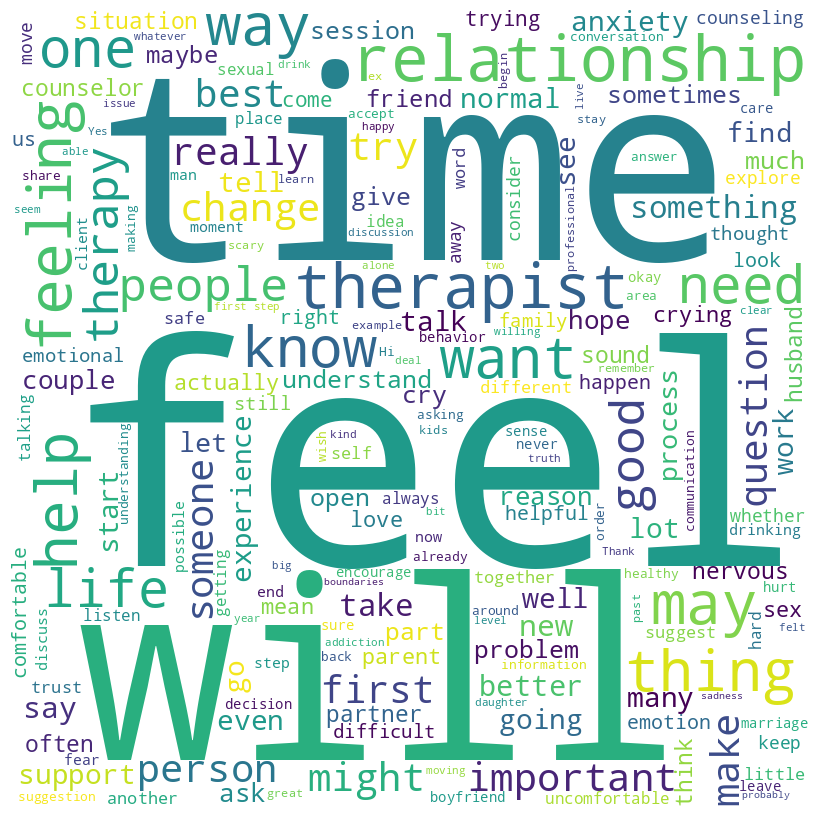

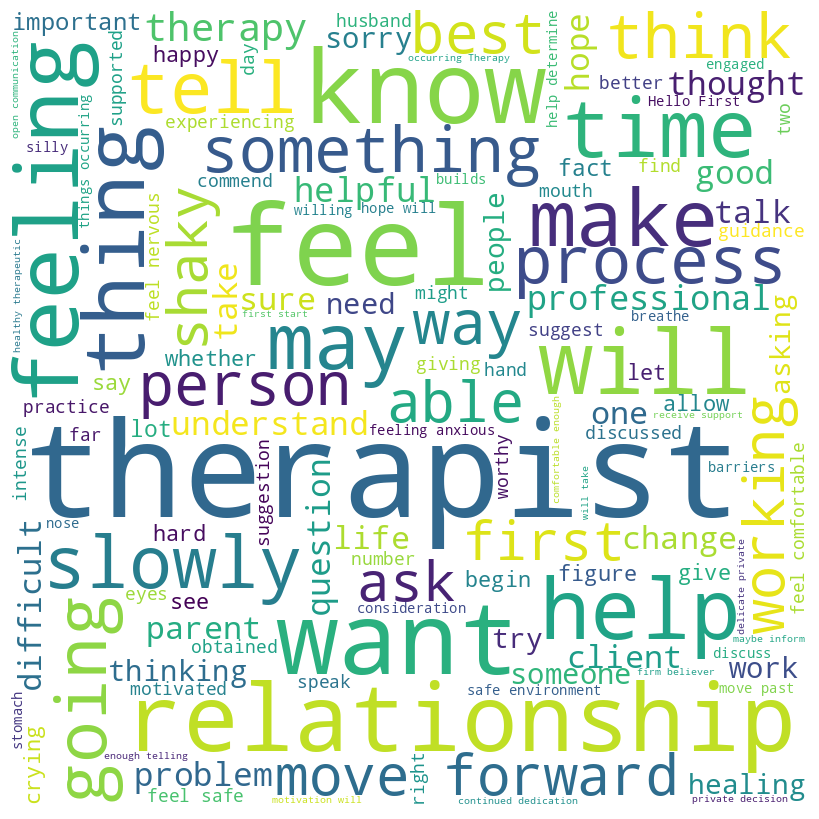

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Read the dataset
df = pd.read_csv("Results.csv")

# Generate word clouds for the 'Query' column
query_cloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(df['Query'].astype(str)))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(query_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Generate word clouds for the 'Response' column
response_cloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(df['Response'].astype(str)))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(response_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Generate word clouds for the 'Generated Response' column
gen_response_cloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(df['Generated Response'].astype(str)))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(gen_response_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


**Interactive Chat**

In [10]:
for step in range(1):
  inp = input("User:\n")
  pref = "question: "+inp+" context:"
  print("Chatbot:")
  gpt2.generate(sess,
                prefix= pref,
                top_k=10, 
                top_p=0.7,
                temperature = 0.8,
                nsamples=1,
                batch_size=1,
                run_name='runf',
                truncate=' <|endoftext|>',
                include_prefix=False,
                )

Chatbot:
 You do not have too many issues to address in counseling.  And your perseverance will serve you well if you choose to engage in therapy.  The trauma and medical event you experienced topped off with chronic sleepless nights would lead to feelings of depression for many.  The emotional reaction you've had to these experiences sounds normal albeit troublesome and I would imagine intensely painful at times as well.  Therapy can help prioritize what is the most impactful issue you are grappling with.  I find in therapy that when the central issue is revealed, understood, processed, and understood again in its current context, many other areas of the person's internal experience improve.  It sounds as though something has prevented you from seeking help from a counselor in the past, and it sounds as though you are more seriously considering it now.  Therapy helps and it can help you when you're ready.


Question: "I’m facing severe depression and anxiety and I just feel like I’m going through a lot. This really distracts me and I cant get my mind off the things that are bothering me.  How do I overcome this anxierty and depression?"

Answer = "Have you used meditation or hypnosis? Relaxing the mind and connecting with your true self is a great way to calm your thoughts and get to peace and calm. Hypnosis and meditation have helped a lot of people with anxiety and depression. Google hypnotherapists near me or write for a while about what is going on."

Question: "Every winter I find myself getting sad because of the weather. How can I fight this?"

Answer= "Seasonal Affective Disorder (S.A.D.) is a term that reflects how many people are affected by the changing seasons, especially fall to winter.  Everyone suffers with some form of this (lessened activity levels, increased isolation, etc.) while some find that this time of year can put them into a deeper depression. If you have noticed that this happens frequently, there are some ways you can definitely help yourself going forward:1. Attend therapy to learn strategies and tools to help you to manage your mood.  It's important to stay within the therapy until you feel you have mastered these tools. 2. Push yourself to interact more with your social groups and other positive activities. It's easy to go out and spend the day outside in the summer months, when the temperature is warm and the sun shines for long periods of the day, but it seems harder to find fun ways to spend your time when the temperature drops and darkness comes on so quickly.  Perhaps winter time could become the time of year where you and your friends have weekly board game nights, complete with hot chocolate and a fire?3. You may want to consider the purchase of a S.A.D. Light.  These are lights that expose you to additional ultra violet light to increase the vitamin D in our bodies, as well as the release of growth hormone (which releases when we wake up). There are mixed reviews of these products, however, and they can be expensive."

Question: """I have so many issues to address. I have a history of sexual abuse, I’m a breast cancer survivor and I am a lifetime insomniac.  I have a long history of depression and I’m beginning to have anxiety. I have low self esteem but I’ve been happily married for almost 35 years.
 I’ve never had counseling about any of this. Do I have too many issues to address in counseling?"""

Answer = "You do not have too many issues to address in counseling.  And your perseverance will serve you well if you choose to engage in therapy.  The trauma and medical event you experienced topped off with chronic sleepless nights would lead to feelings of depression for many.  The emotional reaction you've had to these experiences sounds normal albeit troublesome and I would imagine intensely painful at times as well.  Therapy can help prioritize what is the most impactful issue you are grappling with.  I find in therapy that when the central issue is revealed, understood, processed, and understood again in its current context, many other areas of the person's internal experience improve.  It sounds as though something has prevented you from seeking help from a counselor in the past, and it sounds as though you are more seriously considering it now.  Therapy helps and it can help you when you're ready."